<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re

from sklearn.metrics.pairwise import cosine_similarity

from tqdm.notebook import tqdm

In [21]:
import nltk
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [22]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!wget https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1

--2023-11-13 17:20:40--  https://zenodo.org/record/1199620/files/SO_vectors_200.bin?download=1
Resolving zenodo.org (zenodo.org)... 188.185.33.206, 188.185.10.78, 188.185.22.33, ...
Connecting to zenodo.org (zenodo.org)|188.185.33.206|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1199620/files/SO_vectors_200.bin [following]
--2023-11-13 17:20:40--  https://zenodo.org/records/1199620/files/SO_vectors_200.bin
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1453905423 (1.4G) [application/octet-stream]
Saving to: ‘SO_vectors_200.bin?download=1.1’

SO_vectors_200.bin? 100%[===================>]   1.35G  20.5MB/s    in 69s     

2023-11-13 17:21:50 (20.1 MB/s) - ‘SO_vectors_200.bin?download=1.1’ saved [1453905423/1453905423]



In [25]:
wv_embeddings = KeyedVectors.load_word2vec_format("SO_vectors_200.bin?download=1", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [26]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [27]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}")

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слово `cat` в топ-5 близких слов к слову `dog`? Какое место?

In [28]:
TARGET = 'dog'
df = pd.DataFrame(wv_embeddings.most_similar(TARGET)[:5], columns = ['word', 'sim'])
display(df)
if 'cat' in df['word']:
    place = df.loc[df['word']=='cat'].index + 1
    print('\nСлово \033[1mcat\033[0m входит в \033[1mTOP-5\033[0m близких слов к слову '
         f'\033[1mdog\033[0m. Занимает {place} место')
else:
  word = df.loc[df['word'].str.contains('cat')]['word'].tolist()[0]
  print('\nСлово \033[1mcat\033[0m не входит в \033[1mTOP-5\033[0m близких слов к слову '
        f'\033[1mdog\033[0m. \nВходит слово - \033[1m{word}\033[0m')

,word,sim
0,animal,0.856418
1,dogs,0.788087
2,mammal,0.762380
3,cats,0.762125
4,animals,0.760794



Слово cat не входит в TOP-5 близких слов к слову dog. 
Входит слово - cats


### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [29]:
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text)

In [30]:
tokenizer = MyTokenizer()

In [31]:
text = 'I love neural networks'
tokenizer.tokenize(text)

['I', 'love', 'neural', 'networks']

In [32]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        return: векторное представление для вопроса
    """
    vec = np.zeros((dim), dtype=np.float32)
    if question == "":
        return vec
    cnt = 0
    words = tokenizer.tokenize(question)
    for word in words:
        if word in embeddings.key_to_index:
            vec += embeddings[word]
            cnt += 1
    if cnt > 1:
        vec = vec / cnt
    return vec

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [33]:
text = 'I love neural networks'
comp = question_to_vec(text, wv_embeddings, tokenizer)[2]
round_comp = round(comp, 2)
print('Третья компонента вектора предложения'
      f'\033[1m "{text}"\033[0m:')
print(round_comp)

Третья компонента вектора предложения "I love neural networks":
-1.29


### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями.

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

Максимальное значение Hits@47 - DCG@1 = 1. Для Hits@47
 = 1, для $$ \text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0,$$
Соответственно, ответ 1

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера.
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$ (округлите до одного знака после запятой)

In [34]:
def dcg_score(K: int, ranq: int) -> float:
    flag = 1. * (ranq <= K)
    score = (1 / np.log2(1+ranq)) * flag
    return round(score, 1)

In [35]:
score = dcg_score(K=10, ranq=9)
print(f'\033[1mDCG@10\033[0m равен {score}')

DCG@10 равен 0.3


### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [36]:
def hits_count(dup_ranks, K):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    hits_value = np.mean(np.array(dup_ranks) <= K)
    return hits_value

In [37]:
def dcg_score(dup_ranks, K):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    ranks = np.array(dup_ranks)
    flag = 1. * (ranks <= K)
    dcg_value = np.mean(1 / np.log2(1 + ranks) * flag)
    return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [38]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наги кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [candidates_ranking[i].index(copy_answers[i]) + 1 for i in range(len(copy_answers))]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.63093, 0.63093, 0.63093]


У вас должно получиться

In [39]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

Считайте данные.

In [40]:
!unzip /content/drive/MyDrive/data/stackoverflow_similar_questions.zip

Archive:  /content/drive/MyDrive/data/stackoverflow_similar_questions.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/train.tsv          
  inflating: data/validation.tsv     


In [41]:
def read_corpus(filename):
    data = []
    for line in open(filename, encoding='utf-8'):
        data.append(line.strip().split('\t'))
    return data

Нам понадобиться только файл validation.

In [42]:
validation_data = read_corpus('./data/validation.tsv')

In [43]:
sizes = {}
for i in range(5):
    sizes[i + 1] = len(validation_data[i])

print(f'Количество строк: {len(validation_data)}')
print(f'Размер нескольких первых строк строк: {sizes}')

Количество строк: 3760
Размер нескольких первых строк строк: {1: 1001, 2: 1001, 3: 1001, 4: 1001, 5: 1001}


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [44]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    question_vec = [question_to_vec(question, embeddings, tokenizer, dim)]
    candidates_vec = [question_to_vec(sentence, embeddings, tokenizer, dim)
                      for sentence in candidates]
    ranks = np.argsort(cosine_similarity(question_vec, candidates_vec).ravel())[::-1]

    result = [(x, candidates[x]) for x in ranks]

    return result

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [45]:
questions = ['converting string to list', 'Sending array via Ajax fails']

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],

              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [46]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(1, 'WPF- How to update the changes in list item of a list'), (0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

```python

# должно вывести
results = [[(1, 'C# create cookie from string and send it'),
            (0, 'Convert Google results object (pure js) to Python object'),
            (2, 'How to use jQuery AJAX for an outside domain?')],
           [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
            (*, 'select2 not displaying search results'), #скрыт
            (*, 'WPF- How to update the changes in list item of a list')]] #скрыт
```

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

Последовательность начальных индексов вы должны получить `для эксперимента 2`  1, 0, 2.

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [47]:
wv_ranking = []
max_validation_examples = 1000
with tqdm(desc="Corpus processed", total=max_validation_examples) as pbar_outer:
  for i, line in enumerate(validation_data):
      if i == max_validation_examples:
          break
      q, *ex = line
      ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
      wv_ranking.append([r[0] for r in ranks].index(0) + 1)
      pbar_outer.update(1)

Corpus processed:   0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.228 | Hits@   1: 0.228
DCG@   5: 0.285 | Hits@   5: 0.336
DCG@  10: 0.303 | Hits@  10: 0.392
DCG@ 100: 0.349 | Hits@ 100: 0.622
DCG@ 500: 0.374 | Hits@ 500: 0.821
DCG@1000: 0.393 | Hits@1000: 1.000


### Эмбеддинги, обученные на корпусе похожих вопросов

In [49]:
train_data = read_corpus('./data/train.tsv')

Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

Результаты исследования в выводах - пробовали различные варианты токенизации, нормализации, окон, min_count - результаты приведены в выводах (было предпринято множество различных подходов для решения поставленной задачи и выбран лучший вариант, представленный в текущем варианте решения. Все подходы описаны в выводах с результатми исследований).

Лучший вариант на кастомном словаре достигли с применением старого токенизатора, просто разделяющего предложения на слова, window брали 5 по минимальной длине предложения, min_count, равный 5, размерность - 300.

Примечание: ниже представлен токенизатор с нормализацией и стоп-словами. Но от него отказались в пользу обучной токенизации (разделении по словам) - что позволило повысить качество ранжирования, почти равное словарю SO, ранее обученному, который мы применяли с валидационным сетом

In [50]:
# токенизатор с лемматизацией
# с ним получались результаты хуже

class MyNewTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        text = text.lower()
        lemmatizer = WordNetLemmatizer()
        tokenized = nltk.word_tokenize(text)
        filtered_sentence = [w for w in tokenized if not w in stopwords]
        # глаголы
        lemmatized_output = [lemmatizer.lemmatize(w, pos='v') for w in filtered_sentence]
        # существительные
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in lemmatized_output])
        text_only = re.sub(r"[^+a-z]", ' ', lemmatized_output)
        final = ' '.join(text_only.split())
        return final

Соберем корпус, склеив вопросы по парам, затем проверим максимальные и средние значения длины предложений в корпусе

In [51]:
# склеиваем вопросы, чтобы в листе были только по 2 приложения на индекс
# если больше - то первое не трогаем, похожие - объединяем

new_corpus = []
print("Формирую корпус")
for i in tqdm(range(len(train_data))):
  len_ = len(train_data[i])
  if len_ > 2:
    new_corpus.append([train_data[i][0], ','.join(train_data[i][1:])])
  else:
    new_corpus.append(train_data[i])

# находим длины предложений

print("Отбираю длины вопросов")
corpus_examples_len = []
for i in tqdm(range(len(new_corpus))):
  for j in range(len(new_corpus[i])):
    len_ = len(new_corpus[i][j].split())
    if len_ == 1:
      pass
    else:
      corpus_examples_len.append(len_)

Формирую корпус


  0%|          | 0/1000000 [00:00<?, ?it/s]

Отбираю длины вопросов


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [52]:
mean_words = np.mean(corpus_examples_len)
min_words = np.min(corpus_examples_len)
window = np.floor((min_words)) + 3
print(f'Средняя длина вопроса в корпусе: {round(mean_words, 2)}. ')
print(f'Минимальная длина вопроса в корпусе: {round(min_words, 2)}. ')
print(f'Ширина окна: {window}. ')

Средняя длина вопроса в корпусе: 9.46. 
Минимальная длина вопроса в корпусе: 2. 
Ширина окна: 5.0. 


Превратим мультисписок в обычный

In [53]:
train = [item for sublist in tqdm(new_corpus) for item in sublist]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [54]:
train[:5]

['converting string to list',
 'Convert Google results object (pure js) to Python object',
 'Which HTML 5 Canvas Javascript to use for making an interactive drawing tool?',
 'Event handling for geometries in Three.js?',
 'Sending array via Ajax fails']

Теперь мы можем создать списки слов, представленных в корпусе, затем обучим на них Word2Vec модель. Токенайзер будем использовать старый, без нормализации

In [55]:
tokenizer = MyTokenizer()

In [56]:
proc_words = [tokenizer.tokenize(text) for text in tqdm(train)]

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [57]:
proc_words[:2]

[['converting', 'string', 'to', 'list'],
 ['Convert',
  'Google',
  'results',
  'object',
  'pure',
  'js',
  'to',
  'Python',
  'object']]

Мы выделили из предложений слова. Обучим нашу модель. Размерность поставим равную 300

In [58]:
embeddings_trained = Word2Vec(proc_words,  # data for model to train on
                 vector_size=300,          # embedding vector size
                 min_count=5,              # consider words that occured at least 5 times
                 window=window).wv

In [61]:
print(embeddings_trained.index_to_key[:10])

['to', 'in', 'a', 'How', 'the', 'of', 'with', 'and', 'from', 'for']


In [64]:
vocab_custom = len(embeddings_trained.key_to_index)
vocab_pretrained = len(wv_embeddings.key_to_index)
frac = (1 - (vocab_custom/vocab_pretrained)) * 100
print('Длина словаря кастомного: %.0f слов' %(vocab_custom))
print('Длина словаря SO_vectors_200: %.0f слов' %(vocab_pretrained))
print(f'Обученный на SO словарь больше кастомного на {frac:.2f} %')

Длина словаря кастомного: 50830 слов
Длина словаря SO_vectors_200: 1787145 слов
Обученный на SO словарь больше кастомного на 97.16 %


In [65]:
wv_ranking = []
max_validation_examples = 1000
dim = 300
with tqdm(desc="Corpus processed", total=max_validation_examples) as pbar_outer:
  for i, line in enumerate(validation_data):
      if i == max_validation_examples:
          break
      q, *ex = line
      ranks = rank_candidates(q, ex, embeddings_trained, tokenizer, dim=dim)
      wv_ranking.append([r[0] for r in ranks].index(0) + 1)
      pbar_outer.update(1)

Corpus processed:   0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.244 | Hits@   1: 0.244
DCG@   5: 0.305 | Hits@   5: 0.360
DCG@  10: 0.330 | Hits@  10: 0.437
DCG@ 100: 0.378 | Hits@ 100: 0.675
DCG@ 500: 0.408 | Hits@ 500: 0.907
DCG@1000: 0.418 | Hits@1000: 1.000


Посмотрим как меняется качество, если использовать нормализации и новый токенайзер в совокупности с ранее обученным словарем - wv_embeddings

In [69]:
wv_ranking = []
max_validation_examples = 1000

with tqdm(desc="Corpus processed", total=max_validation_examples) as pbar_outer:
  for i, line in enumerate(validation_data):
      if i == max_validation_examples:
          break
      q, *ex = line
      ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
      wv_ranking.append([r[0] for r in ranks].index(0) + 1)
      pbar_outer.update(1)

Corpus processed:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.228 | Hits@   1: 0.228
DCG@   5: 0.285 | Hits@   5: 0.336
DCG@  10: 0.303 | Hits@  10: 0.392
DCG@ 100: 0.349 | Hits@ 100: 0.622
DCG@ 500: 0.374 | Hits@ 500: 0.821
DCG@1000: 0.393 | Hits@1000: 1.000


## ВЫВОДЫ

Мы провели работу с данными по вопросам Stack Overflow. Посмотрим наиболее часто встречающиеся слова с помощью облака слов. Для этого обработаем и подготовим строку из нашего корпуса, выделив только отдельные слова. Сделаем на примере валидационного сета

In [71]:
tokenizer = MyNewTokenizer()

In [72]:
corpus = []
max_examples = len(validation_data)
with tqdm(desc="Corpus processed", total=max_examples) as pbar_outer:
  for i, line in enumerate(validation_data):
      if i == max_examples:
          break
      q, *ex = line
      corpus.append(tokenizer.tokenize(q))
      pbar_outer.update(1)
  corpus = (" ").join(corpus)

Corpus processed:   0%|          | 0/3760 [00:00<?, ?it/s]

Построим наше облако

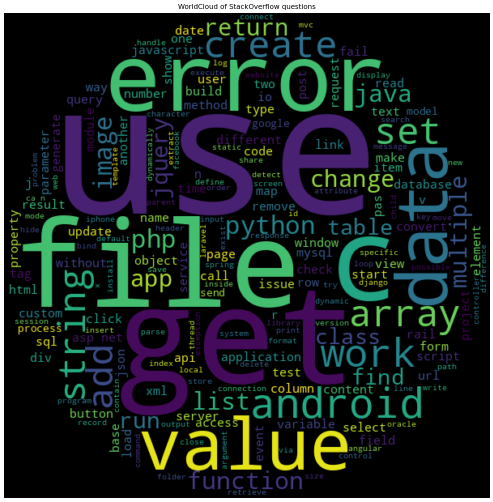

In [73]:
x, y = np.ogrid[:600, :600]

mask = (x - 300) ** 2 + (y - 300) ** 2 > 300 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="black",
               random_state=42, mask=mask, repeat=False,
               stopwords=stopwords).generate(corpus)

plt.figure(figsize=(25, 15), dpi=42)
plt.imshow(wc, interpolation='bilinear')
plt.title("WorldCloud of StackOverflow questions")
plt.axis("off")
plt.show()

Не удивительно, что чаще всего в попросаз попадаются слова use, file, error, data и другие. Сравним результаты исследований на валидации и полученные DCG- и Hits-scores. Ниже приведены результаты использования различных подходов к токенизации и предварительной обработки текста, а также есть вариант использования старого словаря. Лучшие результаты были достигнуты на кастомной модели, так как словарь содержал больше релевантных слов, и к тому же, мы увеличили размерность эмбеддингов

```python

1. tokenizer старый для сравнения: re.findall('\w+', text)
       
        DCG@   1: 0.228 | Hits@   1: 0.228
        DCG@   5: 0.285 | Hits@   5: 0.336
        DCG@  10: 0.303 | Hits@  10: 0.392
        DCG@ 100: 0.349 | Hits@ 100: 0.622
        DCG@ 500: 0.374 | Hits@ 500: 0.821
        DCG@1000: 0.393 | Hits@1000: 1.000


2. tokenizer новый - к нижнему регистру, лемматизация, nltk stopwords.
Обученные эмбеддинги - окно 4, min_count = 5:

        text = text.lower()
        lemmatizer = WordNetLemmatizer()
        tokenized = nltk.word_tokenize(text)
        filtered_sentence = [w for w in tokenized if not w in stopwords]
        lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in filtered_sentence])
        text_only = re.sub(r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", ' ', lemmatized_output)
        final = ' '.join(text_only.split())

        DCG@   1: 0.129 | Hits@   1: 0.129
        DCG@   5: 0.171 | Hits@   5: 0.209
        DCG@  10: 0.185 | Hits@  10: 0.251
        DCG@ 100: 0.231 | Hits@ 100: 0.489
        DCG@ 500: 0.275 | Hits@ 500: 0.838
        DCG@1000: 0.292 | Hits@1000: 1.000

3. tokenizer новый - к нижнему регистру, лемматизация, nltk stopwords.
Обученные эмбеддинги - окно 4, min_count = 3,
re.sub(r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", ' ', lemmatized_output):


        DCG@   1: 0.128 | Hits@   1: 0.128
        DCG@   5: 0.169 | Hits@   5: 0.205
        DCG@  10: 0.183 | Hits@  10: 0.247
        DCG@ 100: 0.232 | Hits@ 100: 0.498
        DCG@ 500: 0.275 | Hits@ 500: 0.840
        DCG@1000: 0.292 | Hits@1000: 1.000

4. tokenizer новый re.sub - оставляем только буквы - к нижнему регистру,
лемматизация, nltk stopwords. Обученные эмбеддинги - окно 5, min_count = 5
re.sub(r"[^a-z]", ' ', lemmatized_output):


        DCG@   1: 0.131 | Hits@   1: 0.131
        DCG@   5: 0.171 | Hits@   5: 0.204
        DCG@  10: 0.185 | Hits@  10: 0.248
        DCG@ 100: 0.233 | Hits@ 100: 0.498
        DCG@ 500: 0.276 | Hits@ 500: 0.836
        DCG@1000: 0.294 | Hits@1000: 1.000


5. tokenizer новый re.sub - оставляем только буквы - к нижнему регистру,
лемматизация ГЛАГОЛОВ, nltk stopwords. Обученные эмбеддинги - окно 2, min_count = 5
re.sub(r"[^a-z]", ' ', lemmatized_output).

        DCG@   1: 0.147 | Hits@   1: 0.147
        DCG@   5: 0.184 | Hits@   5: 0.219
        DCG@  10: 0.194 | Hits@  10: 0.249
        DCG@ 100: 0.245 | Hits@ 100: 0.505
        DCG@ 500: 0.288 | Hits@ 500: 0.841
        DCG@1000: 0.305 | Hits@1000: 1.000

6. tokenizer, лемматизация ГЛАГОЛОВ, nltk stopwords. Обученные эмбеддинги - окно 2, min_count = 1
re.sub ОТСУТСТВУЕТ

      DCG@   1: 0.144 | Hits@   1: 0.144
      DCG@   5: 0.181 | Hits@   5: 0.216
      DCG@  10: 0.191 | Hits@  10: 0.248
      DCG@ 100: 0.243 | Hits@ 100: 0.507
      DCG@ 500: 0.285 | Hits@ 500: 0.837
      DCG@1000: 0.302 | Hits@1000: 1.000


7. tokenizer новый re.sub - оставляем только буквы - к нижнему регистру,
лемматизация ГЛАГОЛОВ, nltk stopwords. Обученные эмбеддинги - окно 2, min_count = 5
re.sub(r"[^+a-z]", ' ', lemmatized_output)

      DCG@   1: 0.151 | Hits@   1: 0.151
      DCG@   5: 0.182 | Hits@   5: 0.211
      DCG@  10: 0.192 | Hits@  10: 0.244
      DCG@ 100: 0.245 | Hits@ 100: 0.506
      DCG@ 500: 0.287 | Hits@ 500: 0.833
      DCG@1000: 0.304 | Hits@1000: 1.000

8. tokenizer новый re.sub - оставляем только буквы - к нижнему регистру,
лемматизация ГЛАГОЛОВ, nltk stopwords. wv_embeddings - ранее обученные на SO
re.sub(r"[^+a-z]", ' ', lemmatized_output)

      DCG@   1: 0.081 | Hits@   1: 0.081
      DCG@   5: 0.118 | Hits@   5: 0.154
      DCG@  10: 0.128 | Hits@  10: 0.184
      DCG@ 100: 0.179 | Hits@ 100: 0.451
      DCG@ 500: 0.221 | Hits@ 500: 0.786
      DCG@1000: 0.244 | Hits@1000: 1.000


9.tokenizer старый. Обученные эмбеддинги - окно 2, min_count = 5

      DCG@   1: 0.211 | Hits@   1: 0.211
      DCG@   5: 0.267 | Hits@   5: 0.320
      DCG@  10: 0.283 | Hits@  10: 0.371
      DCG@ 100: 0.333 | Hits@ 100: 0.621
      DCG@ 500: 0.365 | Hits@ 500: 0.874
      DCG@1000: 0.378 | Hits@1000: 1.000

10. tokenizer старый. Обученные эмбеддинги - окно 5, min_count = 5
Размер латентного пространства - 300


      DCG@   1: 0.245 | Hits@   1: 0.245
      DCG@   5: 0.300 | Hits@   5: 0.350
      DCG@  10: 0.326 | Hits@  10: 0.430
      DCG@ 100: 0.377 | Hits@ 100: 0.680
      DCG@ 500: 0.406 | Hits@ 500: 0.908
      DCG@1000: 0.416 | Hits@1000: 1.000

   


```

Изначально, мы использовали простую токенизацию, разбивая предложения на отдельные слова, не приводя к нижнему регистру, или не используя стоп-слова. В таком случае мы получили достаточно никзие показатели `DCG` и `HITS` на низких значениях K, что равносильно - плохие.

В дальнейшем, мы изменили подход к токенизации. Перед нами не стояла цель классификации тональности, например, или поисков `NER`, поэтому мы решили применить к тексту нижний регистр, также использовали лемматизацию, и еще - `StopWords` из библиотеки `nltk`.

При этом, показатели `DCG` и `Hits` снизились, ухудшились. Мы проводили эксперименты, меняя окно, или параметр `min_count`, используя различные подходы по применениб регулярных выражений, так или иначе, в таком случае - получили результаты хуже, чем при работе с ранее обученным `Word2Vec` словарем - у нас в нем больше слов почти на 96%.

В итоге, увеличение размености эмбеддинга позволило незначительно улучшить результаты.

Стоит отметить, что применение лемматизации и стоп-слов ухудшало качество ранжирования

Плохое качество обусловленно скорее всего тем, что отсутствующие слова не получают эмбеддинг на выходе, а мы получаем вместо - нулевой вектор, то есть теряем информацию. Таким образом, нам могло бы помочь - дообучение нашей модели, либо для отсутствующих слов добавлять, например вектора контекста - средний вектор соседних слов, как пример - тогда все слова были бы обработаны


Отказавшись от нормализации и стоп-слов - мы увеличили количество словарного запаса модели, позволив точнее передавать эмбеддинги предложений, встречалось меньше нулевых векторов, что позволило увеличить передаваемую информацию


**Лучшие результаты мы добились на кастомном словаре  с помощью следующего подхода**:

```tokenizer старый. Обученные эмбеддинги - окно 5, min_count = 5 и размерность dim 300```


Таким образом, при данном подходе - влияете количество релевантных слов в словаре, размерность латентного пространства, принципы токенизации и нормализации, отсутствие или наличие предобработки с помощью регулярных выражений, ширина окна и `min_count`. Дополнительно можно было бы обрабатывать неизвестные слова, с помощью контекста слов